In [1]:
import numpy as np
from skimage import io,color
import cv2 as cv
from scipy.signal import convolve2d
from matplotlib import pyplot as plt
from skimage.filters import gaussian
from scipy.ndimage import gaussian_filter

In [2]:
def make_correction(channel:np.ndarray,mu:float)->np.ndarray:
    channel=channel/255.0
    channel_mean=channel.mean()
    channel_var=channel.var()
    channel_max=channel_mean+mu*channel_var
    channel_min=channel_mean-mu*channel_var
    channel_corrected=255.0*(channel-channel_min)/(channel_max-channel_min)
    channel_corrected=np.clip(channel_corrected,0,255)
    return channel_corrected.astype(np.uint8)

In [3]:
def shrink(x:np.ndarray,eps:float)->float:
    norm=np.linalg.norm(x,ord=2)
    if norm ==0:
        return np.zeros(shape=x.shape)
    ans=x*np.max(norm-eps,0)/norm
    return ans

In [4]:
def get_corrected_image(img:np.ndarray,mu:float)->np.ndarray:
    R,G,B=img[:,:,0],img[:,:,1],img[:,:,2]
    R_corrected,G_corrected,B_corrected=make_correction(R,mu),make_correction(G,mu),make_correction(B,mu)
    corrected_image=np.stack([R_corrected,G_corrected,B_corrected],axis=-1)
    return corrected_image


In [5]:
def RGB2LAB(img:np.ndarray)->tuple[np.ndarray]:
    lab_img=color.rgb2lab(img)
    L,A,B=lab_img[:,:,0],lab_img[:,:,1],lab_img[:,:,2]
    return (L,A,B)

In [6]:
def initialize_RI(L_channel:np.ndarray)->tuple[np.ndarray]:
    height,width=L_channel.shape[0],L_channel.shape[1]
    R=np.zeros(shape=(height,width))
    I0=gaussian_filter(L_channel,sigma=2)
    return (R,I0)

In [7]:
KERNEL_X=np.array([[-1,1]])
KERNEL_Y=np.array([[-1],[1]])

In [8]:
def gradient_x(img:np.ndarray)->np.ndarray:
    kernel_x=np.abs(convolve2d(img,KERNEL_X,mode='same'))
    return np.uint8(kernel_x)

In [9]:
def gradient_y(img:np.ndarray)->np.ndarray:
    kernel_y=np.abs(convolve2d(img,KERNEL_Y,mode='same'))
    return np.uint8(kernel_y)

In [10]:
# delta denotes lambda in original paper we can not use lambda as variable because it is a reserved keyword in python language
def optimizer(R:np.ndarray,I:np.ndarray,I0:np.ndarray,L:np.ndarray,d:np.ndarray,alpha:float=100,beta:float=0.1,gamma:float=1,delta:float=10)->float:
    penalty1=(np.linalg.norm(R*I-L,ord=2))**2
    penalty2=(alpha*(np.linalg.norm(np.vstack((gradient_x(I),gradient_y(I))),ord=2))**2)
    penalty3=(delta*(np.linalg.norm(np.vstack((gradient_x(R),gradient_y(R)))-d,ord=2))**2)
    penalty3=beta*(penalty3+np.linalg.norm(d,ord=1))
    penalty4=gamma*(np.linalg.norm(I-I0,ord=2))**2
    return (penalty1+penalty2+penalty3+penalty4)

In [11]:
def update_d(R:np.ndarray,delta:float=10)->np.ndarray:
    d_x=shrink(gradient_x(R),1.0/2*delta)
    d_y=shrink(gradient_y(R),1.0/2*delta)
    return np.vstack((d_x,d_y))

In [12]:
def denom(D_x:np.ndarray=KERNEL_X,D_y:np.ndarray=KERNEL_Y)->np.ndarray:
    fft_d_x=np.fft.fft(D_x)
    conjugate_fft_d_x=np.conjugate(fft_d_x)
    fft_d_y=np.fft.fft(D_y)
    conjugate_fft_d_y=np.conjugate(fft_d_y)
    return (fft_d_x.dot(conjugate_fft_d_x.T)).squeeze()+(fft_d_y.T.dot(conjugate_fft_d_y)).squeeze()

In [13]:
def update_R(L:np.ndarray,I:np.ndarray,beta:float=0.1,delta:float=10)->np.ndarray:
    numerator=(1+beta*delta)*np.fft.fft(L/I)
    denominator=(np.fft.fft([1])+beta*delta*denom())
    return (np.fft.ifft(numerator/denominator)).real
    

In [14]:
def update_I(I0:np.ndarray,L:np.ndarray,R:np.ndarray,alpha:float=100,gamma:float=1)->np.ndarray:
    numerator=np.fft.fft(gamma*I0+L/R)
    denominator=(np.fft.fft([1+gamma])+alpha*denom())
    return (np.fft.ifft(numerator/denominator)).real

In [65]:
def enhance_R(R:np.ndarray)->np.ndarray:
    clahe=cv.createCLAHE(1,[8,8])
    clahe_result=clahe.apply(R)
    return clahe_result

In [16]:
def LAB2RGB(L:np.ndarray,A:np.ndarray,B:np.ndarray)->np.ndarray:
    h,b=A.shape
    LAB_IMAGE=np.zeros(shape=(h,b,3))
    LAB_IMAGE[:,:,0],LAB_IMAGE[:,:,0],LAB_IMAGE[:,:,0]=L,A,B
    image=color.lab2rgb(LAB_IMAGE)
    return image

In [17]:
image=io.imread("../images/d_r_144_.jpg")

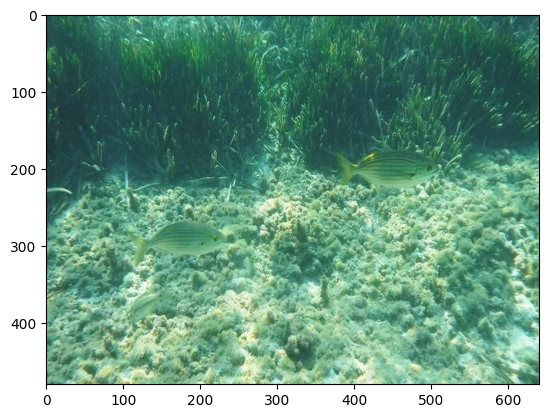

In [18]:
plt.imshow(image)
plt.show()

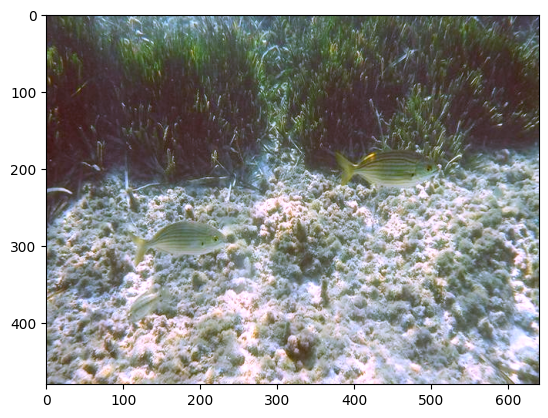

In [19]:
corrected_image=get_corrected_image(image,11)
plt.imshow(corrected_image)
plt.show()

In [20]:
L,A,B=RGB2LAB(corrected_image)

In [21]:
R,Io=initialize_RI(L)

In [22]:
Io.max(),Io.min()

(98.87607146159958, 14.865134987521957)

In [23]:
I=gaussian_filter(L,sigma=3)

In [24]:
I.max(),I.min()

(97.43095202577392, 15.560940227038246)

In [25]:
R=update_R(L,I)

In [26]:
R.max(),R.min()

(0.8084301814553583, 0.04587360028622145)

In [53]:
I=update_I(Io,L,R)

In [54]:
I=np.maximum(L,I)

In [55]:
I.max(),I.min()

(100.0, 5.19714783843191)

In [56]:
R=update_R(L,I)

In [57]:
R.max(),R.min()

(0.2857142857142857, 0.2857142857142857)

In [58]:
I=update_I(Io,L,R)

In [59]:
I.max(),I.min()

(0.745641314720265, 0.07839502381853014)

In [60]:
I=np.maximum(I,L)

In [35]:
I.max(),I.min()

(100.0, 5.19714783843191)

In [51]:
R=update_R(L,I)

In [52]:
R.max(),R.min()

(0.2857142857142857, 0.2857142857142857)

In [38]:
R=R.astype(np.float32)

In [44]:
np.argmax(np.isnan(R))

0

In [48]:
R.max(),R.min()

(0.2857143, 0.2857143)

In [68]:
enhance_R(cv.cvtColor(R,cv.CV_8UC1))

error: OpenCV(4.9.0) d:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.simd_helpers.hpp:94: error: (-2:Unspecified error) in function '__cdecl cv::impl::`anonymous-namespace'::CvtHelper<struct cv::impl::`anonymous namespace'::Set<1,-1,-1>,struct cv::impl::A0x59191d0d::Set<3,4,-1>,struct cv::impl::A0x59191d0d::Set<0,2,5>,4>::CvtHelper(const class cv::_InputArray &,const class cv::_OutputArray &,int)'
> Unsupported depth of input image:
>     'VDepth::contains(depth)'
> where
>     'depth' is 6 (CV_64F)


In [67]:
img=LAB2RGB(R*I,A,B)

C:\Users\rahim\AppData\Local\Temp\ipykernel_2864\1695549420.py:5: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 13287 negative Z values that have been clipped to zero
  image=color.lab2rgb(LAB_IMAGE)


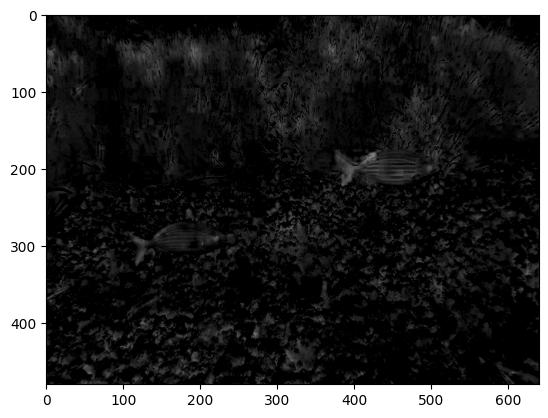

In [63]:
plt.imshow(img)
plt.show()

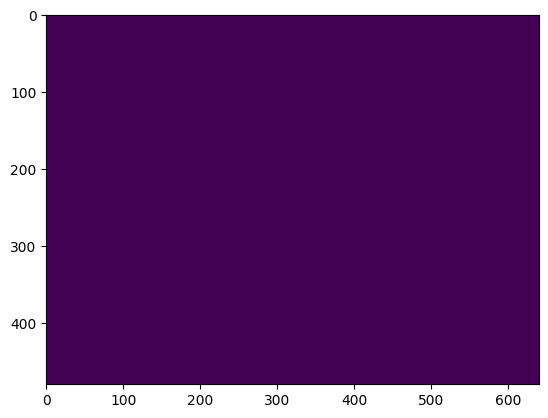

In [69]:
plt.imshow(R)